In [1]:
import random
import math


class BooleanExpressionsTask():

    def __init__(
        self,
        seed: int = 42,
        expression_lengths: tuple = tuple(range(1, 9)),
        max_num_trials: int = 100,
        batch_size: int = 100,
        num_shots: int = 3,
        verbose: bool = False,
        constants: tuple = ("True", "False"),
        binary_ops: tuple = ("or", "and"),
        unary_ops: tuple = ("not",),
        allow_parentheses: bool = True,
    ):
        random.seed(seed)

        if not isinstance(expression_lengths, tuple):
            expression_lengths = (expression_lengths,)

        min_length, max_length = 1, 14
        if any(i < min_length for i in expression_lengths):
            raise ValueError(
                f"Expressions must be greater or equal to "
                f"{min_length} in length, "
                f"got {expression_lengths}."
            )

        if any(i > max_length for i in expression_lengths):
            raise ValueError(
                f"Complexity is exponential in expression length, "
                f"got {expression_lengths} with values more than {max_length}."
            )

        self.expression_lengths = expression_lengths

        self.num_trials = max_num_trials
        self.batch_size = batch_size
        self.verbose = verbose
        self.num_shots = num_shots

        self._start = set(constants + unary_ops)
        self._continue = set(binary_ops)
        self._end = set(constants)

        ops = binary_ops + unary_ops

        self._next = {"start": self._start}

        for c in ops:
            self._next[c] = self._start

        for c in constants:
            self._next[c] = self._continue

        if allow_parentheses:
            self._start.update("(")
            self._end.update(")")
            self._continue.update(")")

            self._next.update({"(": self._start, ")": self._continue})

    def _is_valid(self, expression: tuple, open_parentheses: int) -> bool:
        return open_parentheses == 0 and expression[-1] in self._end

    def _yield_expression(
        self, length: int, prefix: tuple = ("start",), open_parentheses: int = 0
    ):
        if length == 0:
            prefix = prefix[1:]
            if self._is_valid(prefix, open_parentheses):
                yield prefix

        else:
            for t in self._next[prefix[-1]]:
                op = open_parentheses
                if t == "(":
                    op += 1
                elif t == ")":
                    if op == 0:
                        continue
                    op -= 1
                yield from self._yield_expression(length - 1, prefix + (t,), op)

    @classmethod
    def _eval_expression(cls, tokens):
        prompt = " ".join(tokens)
        expected_result = eval(prompt)
        prompt = f"{prompt} is "
        return expected_result, prompt

    def evaluate_model(self, max_examples=None, random_seed=None):

        if random_seed:
            random.seed(random_seed)
        if max_examples:
            self.num_trials = max_examples

        score_data = []

        for length in self.expression_lengths:

            expressions = list(self._yield_expression(length))
            if self.verbose:
                print(
                    f"Generated {len(expressions)} expressions " f"of length {length}."
                )

            expressions = sorted(expressions)
            random.shuffle(expressions)

            inputs = expressions[: self.num_trials * (self.num_shots + 1)]
            n_inputs = len(inputs)
            num_trials = min(self.num_trials, n_inputs)
            num_shots = n_inputs // num_trials - 1

            if self.verbose:
                print(
                    f"Selected total {n_inputs} expressions for prompts and "
                    f"context. Effective number of shots is {num_shots}. "
                    f"Effective number of trials is {num_trials}."
                )

            text_inputs, answers = [], []

            for i in range(0, num_trials * (num_shots + 1), num_shots + 1):
                context = ""
                for b in range(i + 1, i + 1 + num_shots):
                    answer, text_input = self._eval_expression(inputs[b])
                    context += text_input + str(answer) + " . "

                answer, text_input = self._eval_expression(inputs[i])
                text_inputs += [context + text_input]
                answers += [answer]

        return text_inputs, answers

In [2]:
task = BooleanExpressionsTask(verbose=True, expression_lengths= tuple(range(1, 12)), num_shots=0)

In [15]:
dataset = task.evaluate_model(2001)

Generated 2 expressions of length 1.
Selected total 2 expressions for prompts and context. Effective number of shots is 0. Effective number of trials is 2.
Generated 2 expressions of length 2.
Selected total 2 expressions for prompts and context. Effective number of shots is 0. Effective number of trials is 2.
Generated 12 expressions of length 3.
Selected total 12 expressions for prompts and context. Effective number of shots is 0. Effective number of trials is 12.
Generated 22 expressions of length 4.
Selected total 22 expressions for prompts and context. Effective number of shots is 0. Effective number of trials is 22.
Generated 90 expressions of length 5.
Selected total 90 expressions for prompts and context. Effective number of shots is 0. Effective number of trials is 90.
Generated 216 expressions of length 6.
Selected total 216 expressions for prompts and context. Effective number of shots is 0. Effective number of trials is 216.
Generated 770 expressions of length 7.
Selected t

In [16]:
len(dataset[0])

2001

In [17]:
file = open("boolean_expressions.txt", "w")
for i in range(len(dataset[0])):
    file.write(dataset[0][i] + "-" + str(dataset[1][i]) + "\n")

In [2]:
cot_template = """
<|user|>
False or True or not ( True and not True ) is<|end|>  

<|assistant|>
Solving one term at a time:
( True and not True ) is False
not ( True and not True ) is True
False or True or not ( True and not True ) is True
The answer is True.

<|user|>
{question_text}<|end|>  

<|assistant|>
"""

In [18]:
dataset = [[], []]
with open("boolean_expressions.txt", "r") as file:
    for line in file:
        line_ = line.split("\n")[0]
        question, answer = line_.split("-")
        dataset[0].append(question)
        dataset[1].append(answer == "True")

In [20]:
dataset[0] = dataset[0][1:]
dataset[1] = dataset[1][1:]

In [78]:
inp_ = tokenizer.encode(cot_template.format(question=dataset[0][0]), return_tensors="pt").to(device)
model_return = model.generate(inp_, max_length=100, temperature=0.0)

/home/ecabrera/conformal_prediction/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [79]:
model_return = tokenizer.decode(*model_return)
inpt = prompt_template_boolean.format(question_text=model_return)

In [80]:
print(inpt)


<|user|>
<s> 
False or True or not ( True and not True ) is 

Solving one term at a time:
( True and not True ) is False
not ( True and not True ) is True
False or True or not ( True and not True ) is True

False or ( True or True or True ) or True is 

Solving one term at a time:
True or True or True is True
False or True or True is True
Options:
A. true
B. false

Return the letter of the correct answer.
<|assistant|>



In [6]:
device = "cuda:1"

In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct", 
    device_map=device, 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

/home/ecabrera/conformal_prediction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ecabrera/conformal_prediction/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
from tqdm import tqdm
import pandas as pd
import numpy as np

In [9]:
import json

In [9]:
def get_dataset(calibrating = False):    
    files = ["OpenBookQA-V1-Sep2018/Data/Main/train.jsonl", "OpenBookQA-V1-Sep2018/Data/Main/dev.jsonl"]
    if calibrating:
        files = ["OpenBookQA-V1-Sep2018/Data/Main/test.jsonl"]

    lines = []
    for file in files:
        with open(file, "r") as f:
            lines.extend(f.readlines())
            f.close()
            
    lines = [json.loads(line) for line in lines]
    return lines

In [10]:
dataset = get_dataset()
dataset_calibrating = get_dataset(calibrating=True)

In [35]:
prompt_template = """
<|user|>
{question_text}
Options:
A. {text_a}
B. {text_b}
C. {text_c}
D. {text_d}

Return the letter of the correct answer.<|end|> 
<|assistant|>
"""

prompt_template_boolean = """
<|user|>
{question_text}
Options:
A. true
B. false

Return the letter of the correct answer.<|end|> 
<|assistant|>
"""

In [10]:
token_map = {letter: tokenizer.encode(letter)[-1] for letter in "AB"}
letter_to_index_map = {letter: index for index, letter in enumerate([True, False])}

In [194]:
letter_to_index_map

{True: 0, False: 1}

In [11]:
from torch.nn.functional import softmax

In [23]:
results = []
for i in tqdm(range(400)):
    question = dataset[0][i]
    answer = dataset[1][i]
    answer_index  = letter_to_index_map[answer]
    prompt = prompt_template_boolean.format(question_text=question)
    
    prompt_token = tokenizer.encode(prompt, return_tensors="pt").to(device)
    model_return = model(prompt_token, return_dict=True)
    logits = model_return.logits[0, -1, :]
    #probs = softmax(logits, dim=0)
    #sum_probs = probs.sum()
    logits_letter = torch.tensor([logits[token_map[letter]].item() for letter in "AB"])
    results.append(logits_letter.argmax().item() == answer_index)
    
    

100%|██████████| 400/400 [00:14<00:00, 28.45it/s]


In [36]:
results = []
for i in tqdm(range(400)):
    question = dataset[0][i]
    answer = dataset[1][i]
    answer_index  = letter_to_index_map[answer]
    cot_prompt = cot_template.format(question_text=question)
    cot_prompt_token = tokenizer.encode(cot_prompt, return_tensors="pt").to(device)
    model_return = model.generate(cot_prompt_token, max_length=300, temperature=0.0)
    model_return = tokenizer.decode(*model_return)
    
    prompt = prompt_template_boolean.format(question_text=model_return)
    
    prompt_token = tokenizer.encode(prompt, return_tensors="pt").to(device)
    model_return = model(prompt_token, return_dict=True)
    logits = model_return.logits[0, -1, :]
    #probs = softmax(logits, dim=0)
    #sum_probs = probs.sum()
    logits_letter = torch.tensor([logits[token_map[letter]].item() for letter in "AB"])
    results.append(logits_letter.argmax().item() == answer_index)

100%|██████████| 400/400 [20:47<00:00,  3.12s/it]


In [37]:
sum(results) / 400

0.915

In [29]:
results = []
for i in tqdm(range(500)):
    question = dataset[0][i]
    answer = dataset[1][i]
    answer_index  = letter_to_index_map[answer]
    prompt = prompt_template_boolean.format(question_text=question)
    
    prompt_token = tokenizer.encode(prompt, return_tensors="pt").to(device)
    model_return = model(prompt_token, return_dict=True)
    logits = model_return.logits[0, -1, :]
    probs = softmax(logits, dim=0)
    probs = torch.tensor([probs[token_map[letter]].item() for letter in "AB"])
    probs = probs / probs.sum()
    results.append(1 - probs[answer_index].item())

100%|██████████| 500/500 [00:18<00:00, 27.19it/s]


In [228]:
probs

tensor([0.9933, 0.0067])

In [30]:
df = pd.DataFrame(results, columns=["calibrating_scores"])
df

,calibrating_scores
0,0.012432
1,0.407333
2,0.437824
3,0.025957
4,0.268941
...,...
495,0.132964
496,0.997199
497,0.164516
498,0.000231


array([[<Axes: title={'center': 'calibrating_scores'}>]], dtype=object)

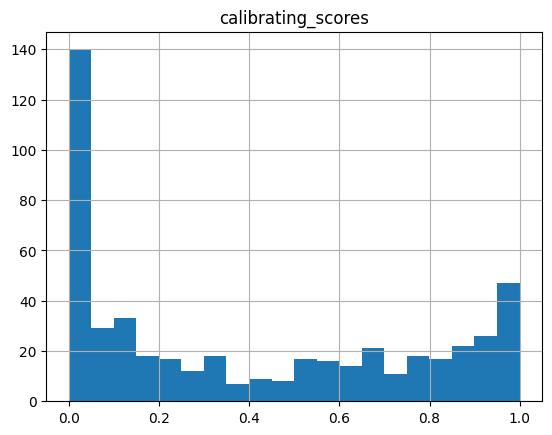

In [31]:
df.hist(bins=20)

In [32]:
n = df.shape[0]
alpha = 0.1
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(df["calibrating_scores"].to_numpy(), q_level, method='higher')

In [33]:
qhat

0.9465966671705246

In [214]:
sum(results) / 400

0.66

In [243]:
letter_to_index_map = {letter: index for index, letter in enumerate("ABCD")}
token_map = {letter: tokenizer.encode(letter)[-1] for letter in "ABCD"}

In [1]:
results = []
for item in tqdm(dataset_calibrating):
    question_id = item["id"]
    question = item["question"]["stem"]
    choices = item["question"]["choices"]
    answerKey = item["answerKey"]
    answerKey_token  = token_map[answerKey]
    prompt = prompt_template.format(question_text=question, text_a=choices[0]["text"], text_b=choices[1]["text"], text_c=choices[2]["text"], text_d=choices[3]["text"])
    
    prompt_token = tokenizer.encode(prompt, return_tensors="pt").to(device)
    model_return = model(prompt_token, return_dict=True)
    logits = model_return.logits[0, -1, :]
    probs = softmax(logits, dim=0)
    sum_probs = probs.sum()
    probs_letter = [probs[token_map[letter]].item() / sum_probs.item() for letter in "ABCD"]
    answerKey_index = letter_to_index_map[answerKey]
    results.append(1-probs_letter[answerKey_index])

NameError: name 'tqdm' is not defined

In [68]:
df = pd.DataFrame(results, columns=["calibrating_scores"])

array([[<Axes: title={'center': 'calibrating_scores'}>]], dtype=object)

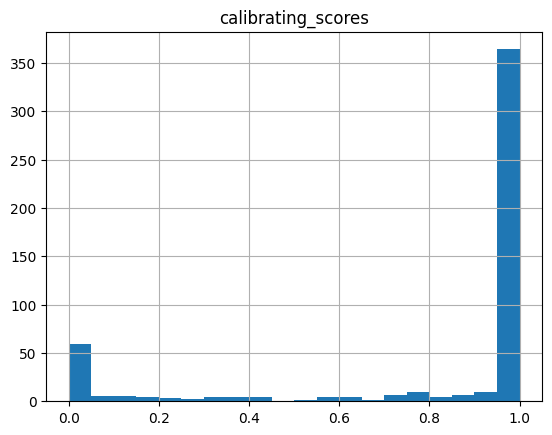

In [73]:
df.hist(bins=20)

In [102]:
n = df.shape[0]
alpha = 0.5
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(df["calibrating_scores"].to_numpy(), q_level, method='higher')

In [103]:
qhat

0.9999891519572373

In [104]:
model.

0.502

In [55]:
df["Correct"] = df["True"] == df["Predicted"]

In [60]:
df[df["Correct"] == False]

,True,Predicted,Correct
12,1,2,False
24,3,1,False
32,2,0,False
33,2,1,False
55,0,1,False
...,...,...,...
5923,2,1,False
5927,1,2,False
5932,3,1,False
5934,2,0,False


In [58]:
df["Correct"].sum() / df.shape[0]

0.8359912707738795

In [32]:
item

{'id': '7-999',
 'question': {'stem': 'Oak tree seeds are planted and a sidewalk is paved right next to that spot, until eventually, the tree is tall and the roots must extend past the sidewalk, which means',
  'choices': [{'text': 'roots may be split', 'label': 'A'},
   {'text': 'roots may begin to die', 'label': 'B'},
   {'text': 'parts may break the concrete', 'label': 'C'},
   {'text': 'roots may fall apart', 'label': 'D'}]},
 'answerKey': 'C'}

In [129]:
prompt = """
<|user|>
{question_text}
Options:
A. {text_a}
B. {text_b}
C. {text_c}
D. {text_d}

Return the letter of the correct answer.
<|assistant|>
"""

In [133]:
prompt_example = prompt.format(question_text=line["question"]["stem"], text_a=line["question"]["choices"][0]["text"], text_b=line["question"]["choices"][1]["text"], text_c=line["question"]["choices"][2]["text"], text_d=line["question"]["choices"][3]["text"])

In [127]:
line = lines[0]
json.loads(line)

{'id': '7-980',
 'question': {'stem': 'The sun is responsible for',
  'choices': [{'text': 'puppies learning new tricks', 'label': 'A'},
   {'text': 'children growing up and getting old', 'label': 'B'},
   {'text': 'flowers wilting in a vase', 'label': 'C'},
   {'text': 'plants sprouting, blooming and wilting', 'label': 'D'}]},
 'answerKey': 'D'}

In [10]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct", 
    device_map="cuda:1", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

/home/ecabrera/conformal_prediction/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [82]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
}

In [7]:
messages = [
    {"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"},
    {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
    {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
]

In [113]:
prompt = """
<|user|>
Who was the firt president of USA?
Options:
A. Abraham Lincoln
B. George Washington
C. Thomas Jefferson
D. John Adams

Return the letter of the correct answer.
<|assistant|>
"""

In [114]:
inp = tokenizer.encode(prompt, return_tensors="pt").to(device="cuda:1")

In [108]:
token_a = tokenizer.encode("A", return_tensors="pt").to(device="cuda:1")
token_b = tokenizer.encode("B", return_tensors="pt").to(device="cuda:1")
token_c = tokenizer.encode("C", return_tensors="pt").to(device="cuda:1")
token_d = tokenizer.encode("D", return_tensors="pt").to(device="cuda:1")
token_space = tokenizer.encode(" ", return_tensors="pt").to(device="cuda:1")

In [109]:
token_a, token_b, token_c, token_d, token_space

(tensor([[  1, 319]], device='cuda:1'),
 tensor([[  1, 350]], device='cuda:1'),
 tensor([[  1, 315]], device='cuda:1'),
 tensor([[  1, 360]], device='cuda:1'),
 tensor([[  1, 259]], device='cuda:1'))

In [116]:
model_return = model(inp, return_dict=True)

In [111]:
inp.shape

torch.Size([1, 48])

In [71]:
model_return.logits[:, :, 319]

tensor([[ 4.7812,  0.3711,  5.1875, 18.6250, 20.2500, 21.6250, 20.7500, 15.0625,
         11.8750, 18.2500,  4.7812,  8.5000,  8.3125, 13.8125, -6.7812, 14.9375,
         15.7500,  7.9688,  6.8750, 17.6250,  5.9375,  9.9375, -2.7812,  6.6562,
         16.8750,  4.9688,  9.9375, -4.0000,  2.7656, 17.2500,  4.5000,  7.1250,
         -4.3750,  5.5000, 17.6250,  3.7500,  4.4062,  7.3125, -3.6250,  0.4453,
         18.6250, 10.4375, 15.8750, 12.0000,  9.4375, 10.5000, 10.5625, 15.0000,
         -3.7500, 40.5000, 16.1250, 24.3750, 30.6250, 23.2500, 19.7500]],
       device='cuda:1', grad_fn=<SelectBackward0>)

In [70]:
model_return.logits[:, :, 350]

tensor([[ 5.1562, -1.2344,  3.7500, 15.8750, 18.0000, 21.1250, 20.6250, 13.7500,
         12.6250, 18.1250,  3.7656,  6.4062,  6.6250, 10.9375, -7.1875,  8.3125,
          9.9375,  0.0364,  9.8750, 16.3750,  3.7500, 10.3750, 10.1250,  4.3750,
         19.2500,  5.7188, 11.1875, -6.6875,  0.2197, 16.6250,  4.9688,  9.1875,
         -6.6875,  5.0000, 16.2500,  7.0000,  5.0625,  7.0938, -4.0625, -0.8008,
         19.8750,  4.7188,  9.9375, 11.4375,  7.2500,  7.0000,  6.8750, 12.5000,
         -6.5625, 31.6250, 14.1875, 21.8750, 24.5000, 19.0000, 13.4375]],
       device='cuda:1', grad_fn=<SelectBackward0>)

In [117]:
model_return.logits[:, -1, 319], model_return.logits[:, -1, 350], model_return.logits[:, -1, 315], model_return.logits[:, -1, 360], model_return.logits[:, -1, 259]

(tensor([17.6250], device='cuda:1', grad_fn=<SelectBackward0>),
 tensor([38.2500], device='cuda:1', grad_fn=<SelectBackward0>),
 tensor([19.2500], device='cuda:1', grad_fn=<SelectBackward0>),
 tensor([21.], device='cuda:1', grad_fn=<SelectBackward0>),
 tensor([18.1250], device='cuda:1', grad_fn=<SelectBackward0>))

In [90]:
output = pipe(prompt, **generation_args)

In [91]:
output

[{'generated_text': ' A'}]